# Time series forecasting (using Facebook Prophet): Air quality (Bangkok)
* Notebook: https://github.com/prasertcbs/scikitlearn_tutorial/blob/main/notebook/timeseries_air_quality.ipynb
* data source: https://aqicn.org/data-platform/register/
* Facebook Prophet: https://facebook.github.io/prophet/
* further reading: https://www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/

---
* author:  [Prasert Kanawattanachai](prasert.k@chula.ac.th)
* YouTube: https://www.youtube.com/prasertcbs
* github: https://github.com/prasertcbs
* [Chulalongkorn Business School](https://www.cbs.chula.ac.th/en/)
---

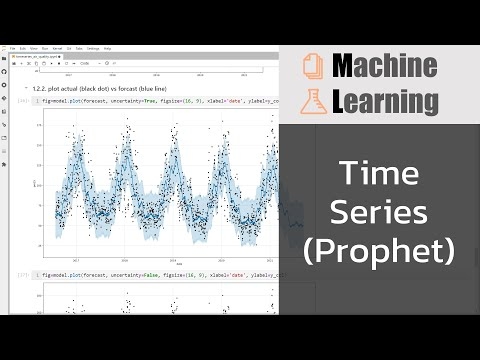

In [8]:
from IPython.display import YouTubeVideo
YouTubeVideo('rNjMs3sn_QM', width=720, height=405)

In [9]:
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [10]:
print(f'Python  version: {sys.version}')
print(f'pandas  version: {pd.__version__}')
print(f'numpy   version: {np.__version__}')
print(f'seaborn version: {sns.__version__}')

pd.Timestamp.now()
# pd.Timestamp.now().strftime('%Y-%m-%d')

Python  version: 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
pandas  version: 1.3.4
numpy   version: 1.20.3
seaborn version: 0.11.2


Timestamp('2022-11-04 18:09:14.518838')

## read and preprocess data

In [11]:
data_url='https://github.com/prasertcbs/basic-dataset/raw/master/bangkok-air-quality.csv'
data=pd.read_csv(data_url, parse_dates=['date'], skipinitialspace=True)
data

,date,pm25,pm10,o3,no2,so2,co
0,2021-03-01,93.0,30.0,8.0,6.0,1.0,NaN
1,2021-03-02,68.0,27.0,7.0,5.0,1.0,NaN
2,2021-03-03,58.0,37.0,13.0,9.0,1.0,NaN
3,2021-03-04,74.0,35.0,13.0,6.0,NaN,NaN
4,2021-03-05,72.0,38.0,15.0,6.0,1.0,NaN
...,...,...,...,...,...,...,...
2619,2015-03-15,NaN,NaN,23.0,13.0,3.0,9.0
2620,2014-11-30,NaN,NaN,40.0,36.0,4.0,11.0
2621,2013-12-31,NaN,NaN,68.0,33.0,3.0,7.0
2622,2014-01-26,NaN,NaN,54.0,53.0,6.0,18.0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2624 entries, 0 to 2623
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2624 non-null   datetime64[ns]
 1   pm25    1680 non-null   float64       
 2   pm10    2609 non-null   float64       
 3   o3      2610 non-null   float64       
 4   no2     2611 non-null   float64       
 5   so2     1877 non-null   float64       
 6   co      963 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 143.6 KB


In [13]:
data=data.sort_values('date').reset_index(drop=True).copy()
data

,date,pm25,pm10,o3,no2,so2,co
0,2013-12-31,NaN,NaN,68.0,33.0,3.0,7.0
1,2014-01-01,NaN,84.0,90.0,48.0,5.0,16.0
2,2014-01-02,NaN,84.0,119.0,63.0,7.0,14.0
3,2014-01-03,NaN,103.0,95.0,57.0,7.0,13.0
4,2014-01-04,NaN,101.0,52.0,34.0,1.0,NaN
...,...,...,...,...,...,...,...
2619,2021-03-10,98.0,53.0,16.0,12.0,1.0,NaN
2620,2021-03-11,111.0,52.0,19.0,10.0,NaN,NaN
2621,2021-03-12,101.0,48.0,15.0,7.0,1.0,NaN
2622,2021-03-13,96.0,32.0,9.0,4.0,1.0,NaN


In [14]:
y_col='pm25'
y_col

'pm25'

In [15]:
data.dropna(subset=[y_col], inplace=True)
data

,date,pm25,pm10,o3,no2,so2,co
938,2016-07-30,61.0,19.0,17.0,15.0,8.0,6.0
939,2016-07-31,68.0,24.0,25.0,13.0,7.0,6.0
940,2016-08-01,60.0,20.0,26.0,14.0,2.0,6.0
941,2016-08-02,68.0,25.0,21.0,14.0,7.0,6.0
942,2016-08-03,70.0,26.0,23.0,16.0,2.0,6.0
...,...,...,...,...,...,...,...
2619,2021-03-10,98.0,53.0,16.0,12.0,1.0,NaN
2620,2021-03-11,111.0,52.0,19.0,10.0,NaN,NaN
2621,2021-03-12,101.0,48.0,15.0,7.0,1.0,NaN
2622,2021-03-13,96.0,32.0,9.0,4.0,1.0,NaN


In [16]:
df=data[['date', y_col]]
df.columns=['ds', 'y'] # ถ้าจะใช้ library นี้ columns ที่เป็น วันเวลา เราจะต้องตั้งชื่อว่า ds ส่วน col ที่เราจะตั้งเป็นค่า y ให้ตั้งชื่อว่า y 
df

,ds,y
938,2016-07-30,61.0
939,2016-07-31,68.0
940,2016-08-01,60.0
941,2016-08-02,68.0
942,2016-08-03,70.0
...,...,...
2619,2021-03-10,98.0
2620,2021-03-11,111.0
2621,2021-03-12,101.0
2622,2021-03-13,96.0


## Time Series Forecasting with Prophet

In [17]:
# install facebook prophet (Time Series analysis)
# !conda install -c "conda-forge/label/prophet_dev" prophet

In [18]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


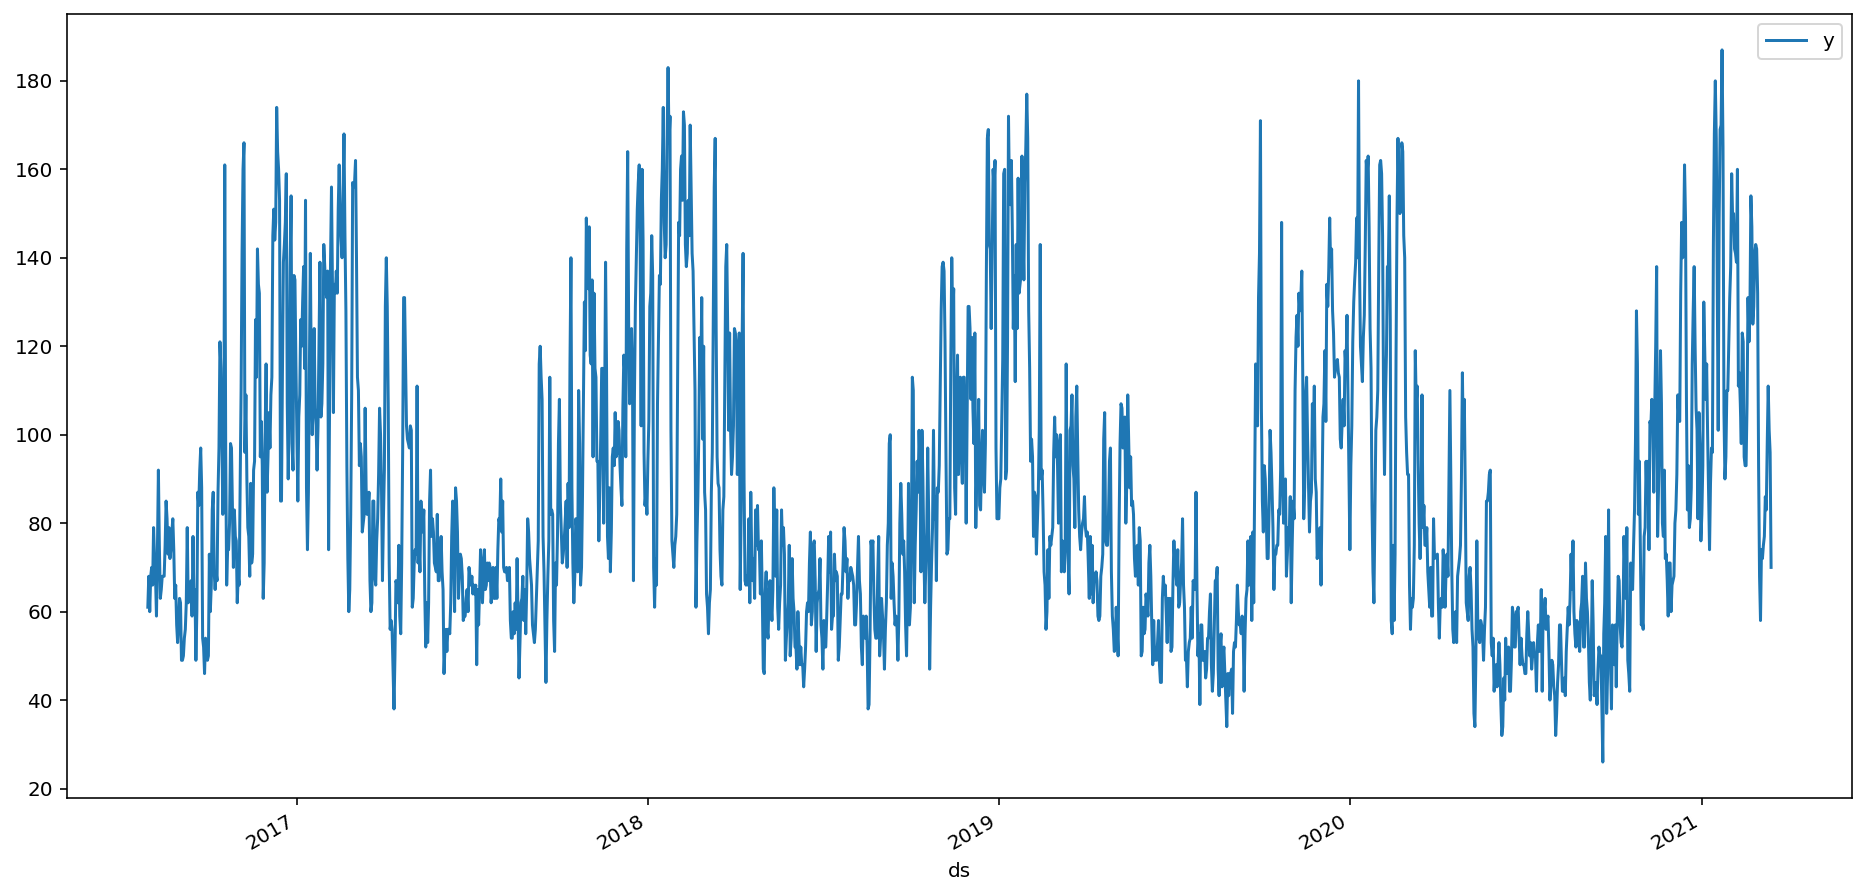

In [19]:
df.set_index('ds').plot(figsize=(16, 8)); # เนื่องจากข้อมูลที่เราจะเอามา plot มี 2 cols โปรเเกรมเลยรู้ว่าอันไหน y ซึ่งอีกอันนึงต้องเป็น x

In [20]:
model=Prophet()

In [21]:
model.__dict__

{'growth': 'linear',
 'changepoints': None,
 'n_changepoints': 25,
 'specified_changepoints': False,
 'changepoint_range': 0.8,
 'yearly_seasonality': 'auto',
 'weekly_seasonality': 'auto',
 'daily_seasonality': 'auto',
 'holidays': None,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 10.0,
 'changepoint_prior_scale': 0.05,
 'holidays_prior_scale': 10.0,
 'mcmc_samples': 0,
 'interval_width': 0.8,
 'uncertainty_samples': 1000,
 'start': None,
 'y_scale': None,
 'logistic_floor': False,
 't_scale': None,
 'changepoints_t': None,
 'seasonalities': OrderedDict(),
 'extra_regressors': OrderedDict(),
 'country_holidays': None,
 'stan_fit': None,
 'params': {},
 'history': None,
 'history_dates': None,
 'train_component_cols': None,
 'component_modes': None,
 'train_holiday_names': None,
 'fit_kwargs': {},
 'stan_backend': <prophet.models.CmdStanPyBackend at 0x1a6fb1fe310>}

In [22]:
model.fit(df)

18:09:58 - cmdstanpy - INFO - Chain [1] start processing
18:10:21 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
df.tail()

,ds,y
2619,2021-03-10,98.0
2620,2021-03-11,111.0
2621,2021-03-12,101.0
2622,2021-03-13,96.0
2623,2021-03-14,70.0


### make_future_dataframe เพื่อใช้ในการทำ model.forecast ไปในอนาคต เช่น 180 วันจากข้อมูล

In [24]:
future=model.make_future_dataframe(periods=180, freq='D') # periods=180, freq='D' --> ทำนาย 180 (periods=180) วัน (freq='D') หลังจากนี้ไป
future.tail()

,ds
1855,2021-09-06
1856,2021-09-07
1857,2021-09-08
1858,2021-09-09
1859,2021-09-10


In [25]:
future.head()

,ds
0,2016-07-30
1,2016-07-31
2,2016-08-01
3,2016-08-02
4,2016-08-03


In [26]:
forecast=model.predict(future)

In [27]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-07-30,88.912329,38.488678,91.665050,88.912329,88.912329,-24.612633,-24.612633,-24.612633,0.034507,0.034507,0.034507,-24.647140,-24.647140,-24.647140,0.0,0.0,0.0,64.299696
1,2016-07-31,88.914428,35.159853,90.547429,88.914428,88.914428,-26.371942,-26.371942,-26.371942,-1.411735,-1.411735,-1.411735,-24.960207,-24.960207,-24.960207,0.0,0.0,0.0,62.542486
2,2016-08-01,88.916527,35.612587,89.399037,88.916527,88.916527,-24.969319,-24.969319,-24.969319,0.279797,0.279797,0.279797,-25.249117,-25.249117,-25.249117,0.0,0.0,0.0,63.947207
3,2016-08-02,88.918625,35.394432,91.447061,88.918625,88.918625,-24.418121,-24.418121,-24.418121,1.088338,1.088338,1.088338,-25.506459,-25.506459,-25.506459,0.0,0.0,0.0,64.500505
4,2016-08-03,88.920724,37.912954,91.552090,88.920724,88.920724,-24.813342,-24.813342,-24.813342,0.912544,0.912544,0.912544,-25.725886,-25.725886,-25.725886,0.0,0.0,0.0,64.107383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1855,2021-09-06,75.479315,22.567118,76.357246,75.358012,75.608113,-25.889362,-25.889362,-25.889362,0.279797,0.279797,0.279797,-26.169159,-26.169159,-26.169159,0.0,0.0,0.0,49.589953
1856,2021-09-07,75.469439,23.528088,77.543203,75.346639,75.599599,-24.870805,-24.870805,-24.870805,1.088338,1.088338,1.088338,-25.959143,-25.959143,-25.959143,0.0,0.0,0.0,50.598634
1857,2021-09-08,75.459562,22.791973,76.991404,75.336024,75.591302,-24.737092,-24.737092,-24.737092,0.912544,0.912544,0.912544,-25.649637,-25.649637,-25.649637,0.0,0.0,0.0,50.722470
1858,2021-09-09,75.449686,20.669135,76.867095,75.325416,75.582488,-25.657262,-25.657262,-25.657262,-0.420806,-0.420806,-0.420806,-25.236456,-25.236456,-25.236456,0.0,0.0,0.0,49.792424


In [28]:
df

,ds,y
938,2016-07-30,61.0
939,2016-07-31,68.0
940,2016-08-01,60.0
941,2016-08-02,68.0
942,2016-08-03,70.0
...,...,...
2619,2021-03-10,98.0
2620,2021-03-11,111.0
2621,2021-03-12,101.0
2622,2021-03-13,96.0


In [29]:
dfcst=forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
dfcst

,ds,yhat,yhat_lower,yhat_upper
0,2016-07-30,64.299696,38.488678,91.665050
1,2016-07-31,62.542486,35.159853,90.547429
2,2016-08-01,63.947207,35.612587,89.399037
3,2016-08-02,64.500505,35.394432,91.447061
4,2016-08-03,64.107383,37.912954,91.552090
...,...,...,...,...
1855,2021-09-06,49.589953,22.567118,76.357246
1856,2021-09-07,50.598634,23.528088,77.543203
1857,2021-09-08,50.722470,22.791973,76.991404
1858,2021-09-09,49.792424,20.669135,76.867095


In [30]:
dt=pd.merge(df, dfcst, left_on='ds', right_on='ds')
dt

,ds,y,yhat,yhat_lower,yhat_upper
0,2016-07-30,61.0,64.299696,38.488678,91.665050
1,2016-07-31,68.0,62.542486,35.159853,90.547429
2,2016-08-01,60.0,63.947207,35.612587,89.399037
3,2016-08-02,68.0,64.500505,35.394432,91.447061
4,2016-08-03,70.0,64.107383,37.912954,91.552090
...,...,...,...,...,...
1675,2021-03-10,98.0,84.469326,58.022444,110.489713
1676,2021-03-11,111.0,81.973266,54.045043,110.030413
1677,2021-03-12,101.0,80.843231,51.936947,109.525178
1678,2021-03-13,96.0,80.396632,52.404867,107.103382


In [31]:
dt.shape

(1680, 5)

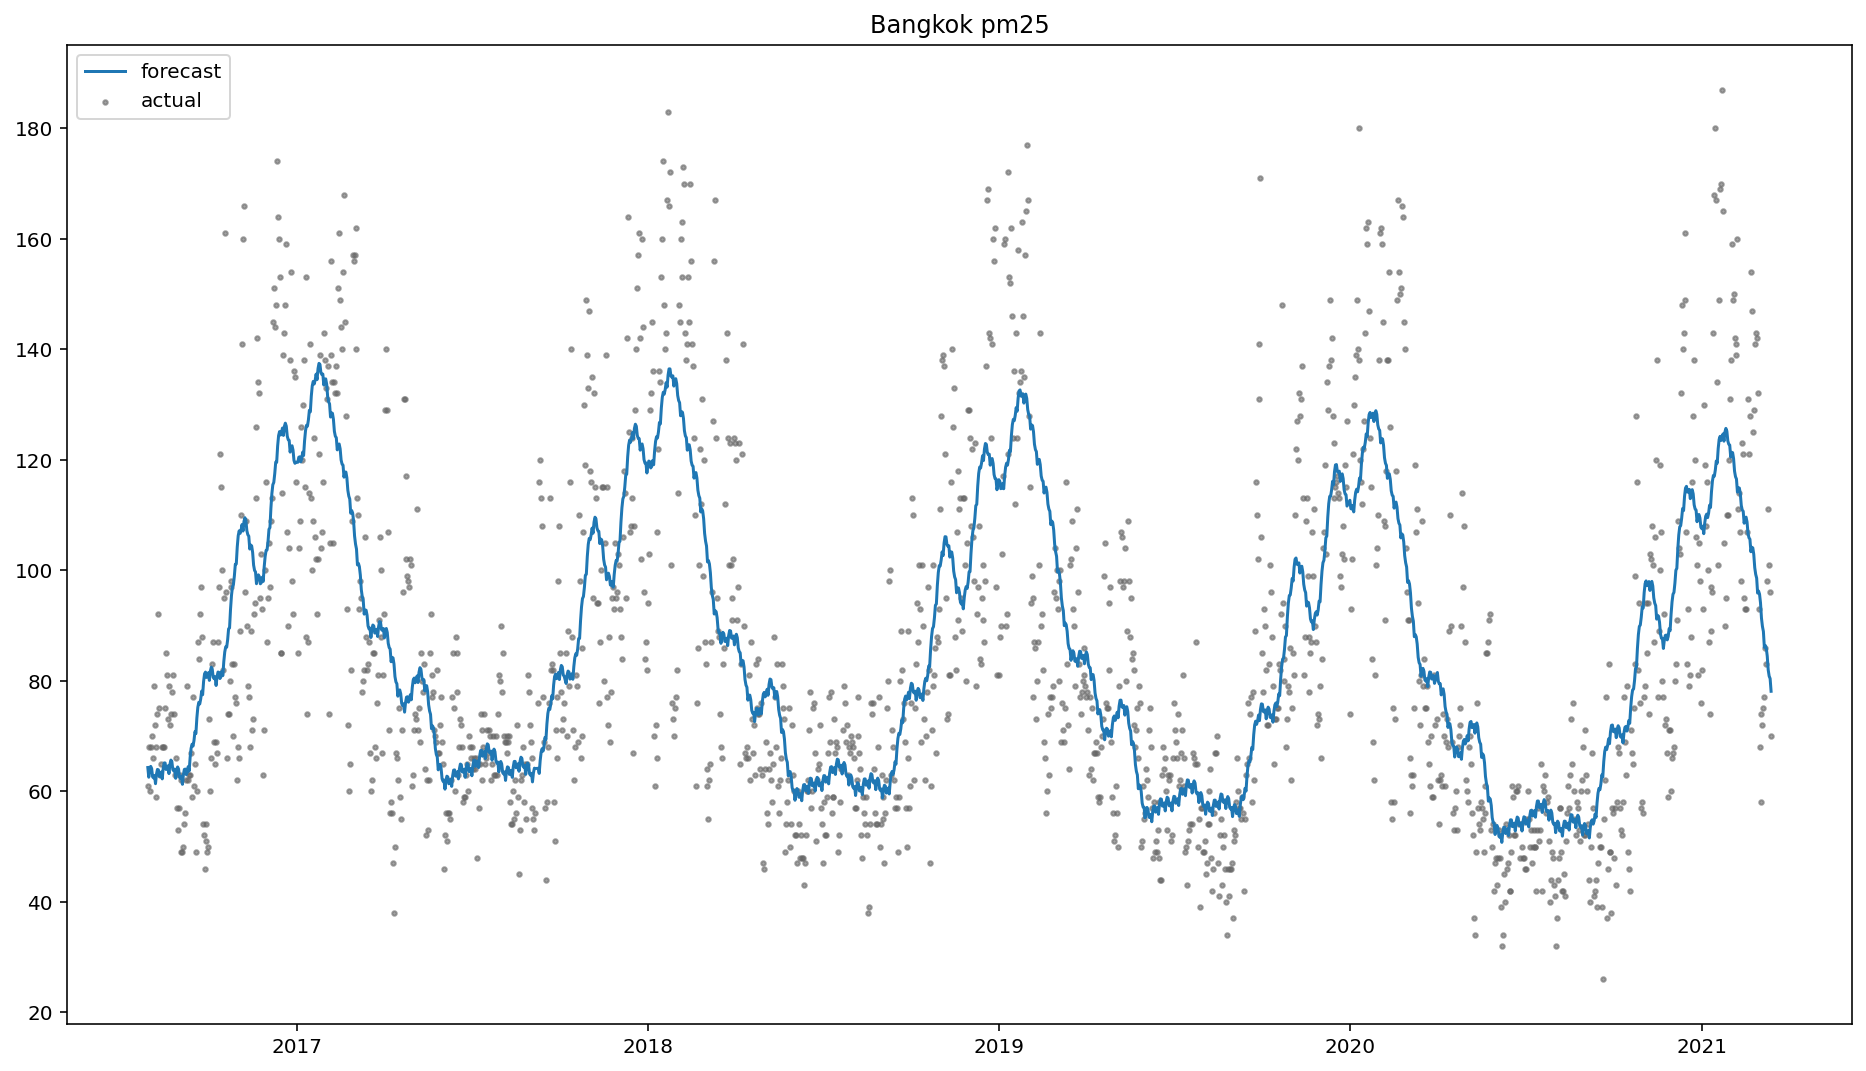

In [32]:
plt.figure(figsize=(16,9))
plt.scatter(dt['ds'], dt['y'], color='.4', label='actual', s=5, alpha=.6) # จุดดำๆ คือ ข้อมูลจริง
plt.plot(dt['ds'], dt['yhat'], label='forecast') # เส้นสีฟ้าคือ forcast
plt.title(f'Bangkok {y_col}')
plt.legend();

### plot actual (black dot) vs forcast (blue line)

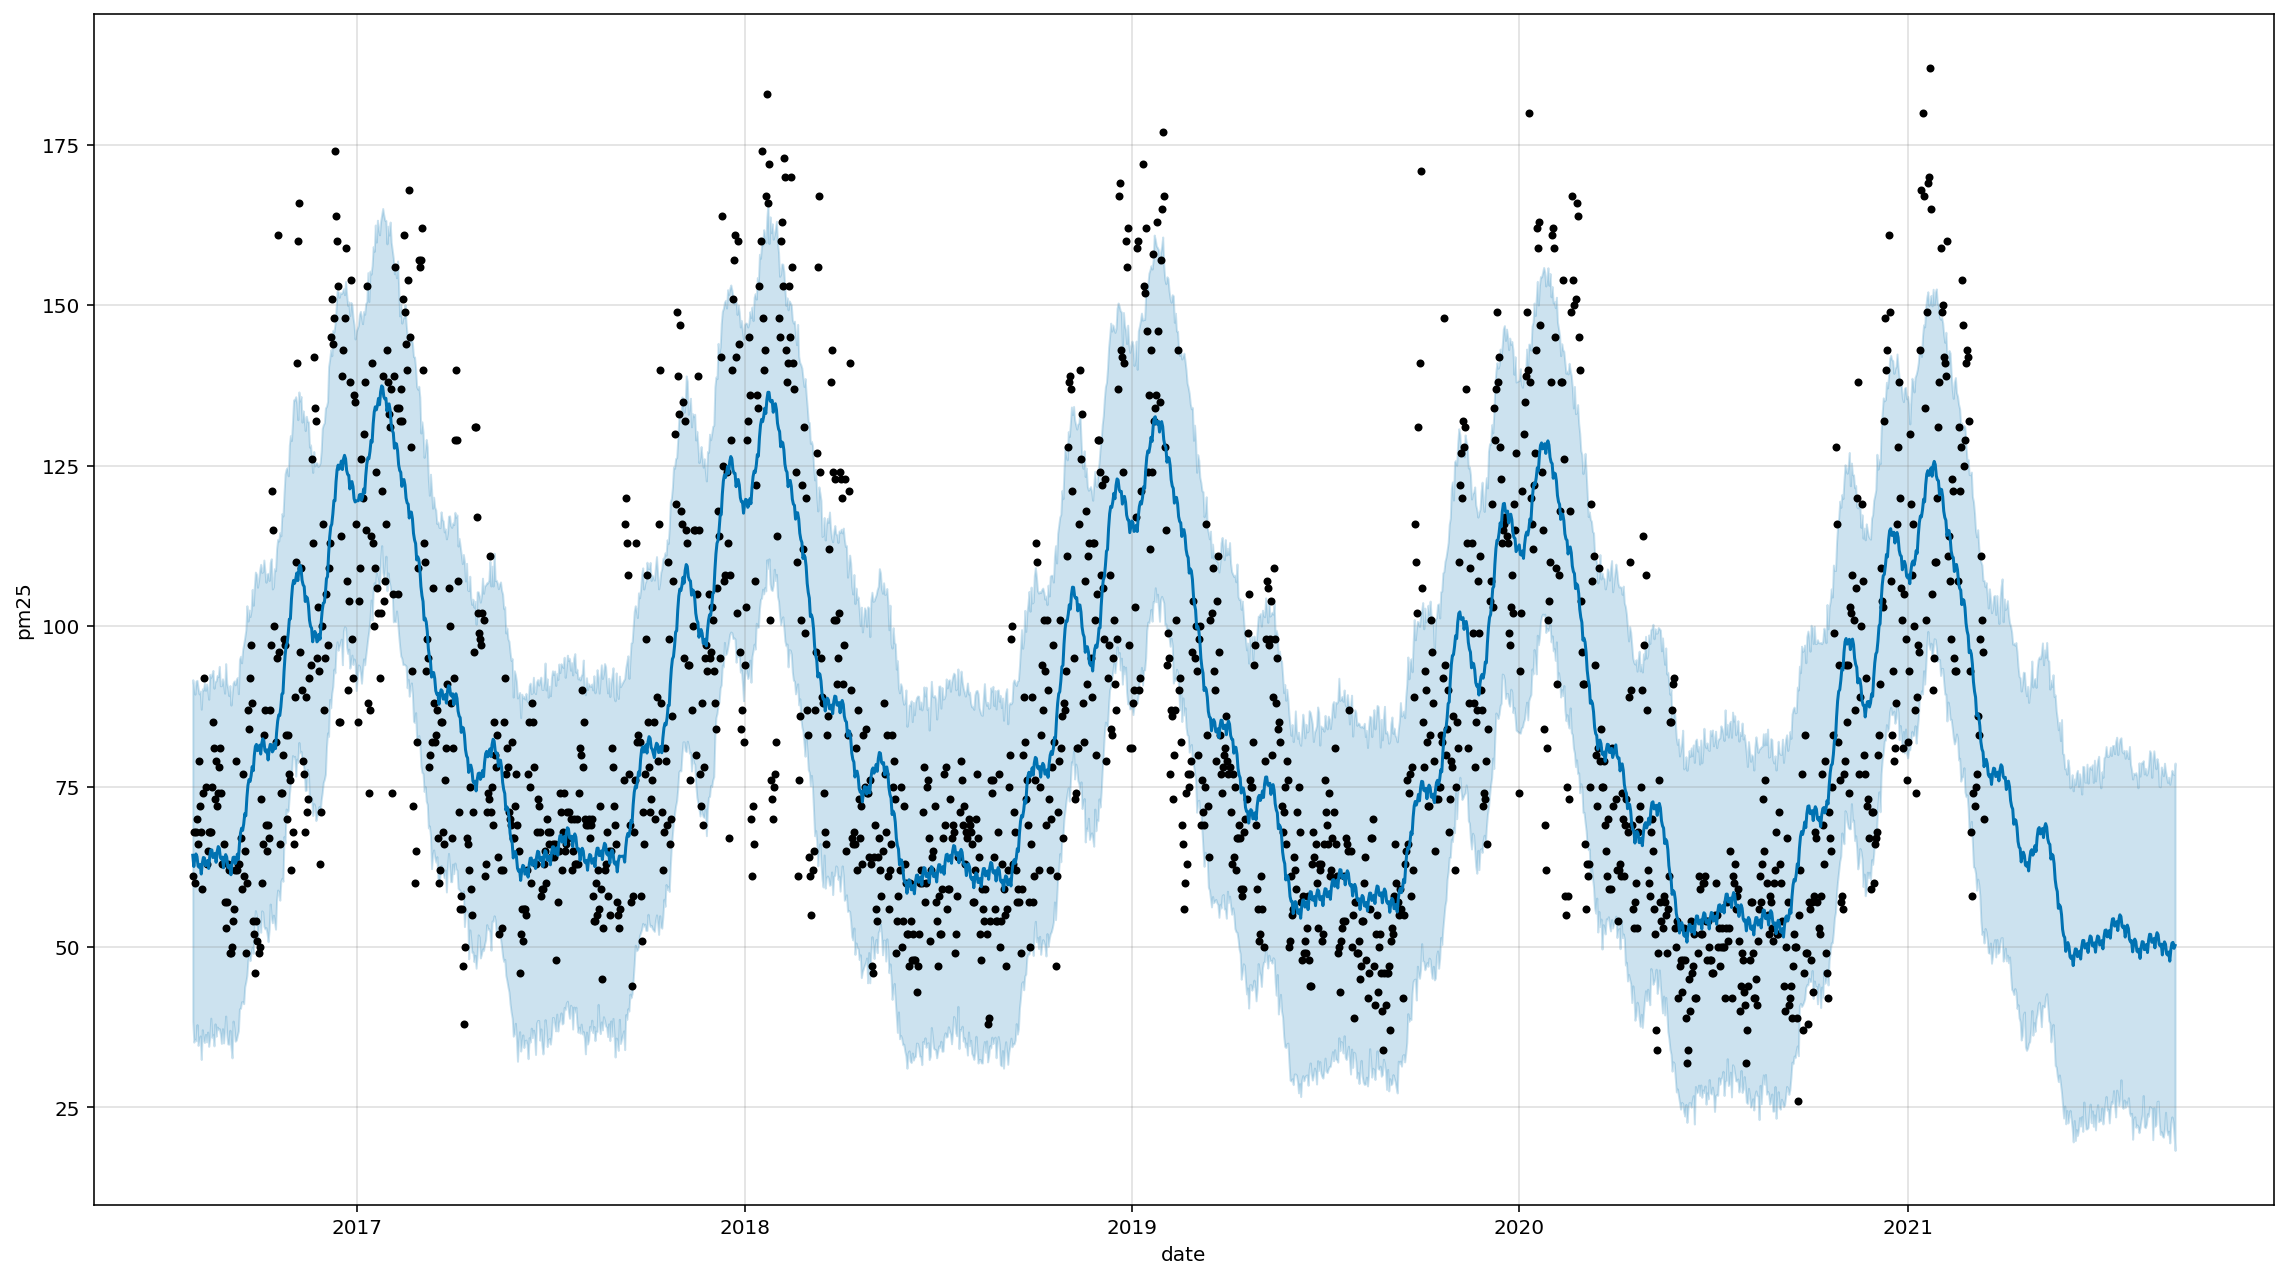

In [33]:
fig=model.plot(forecast, uncertainty=True, figsize=(16, 9), xlabel='date', ylabel=y_col)

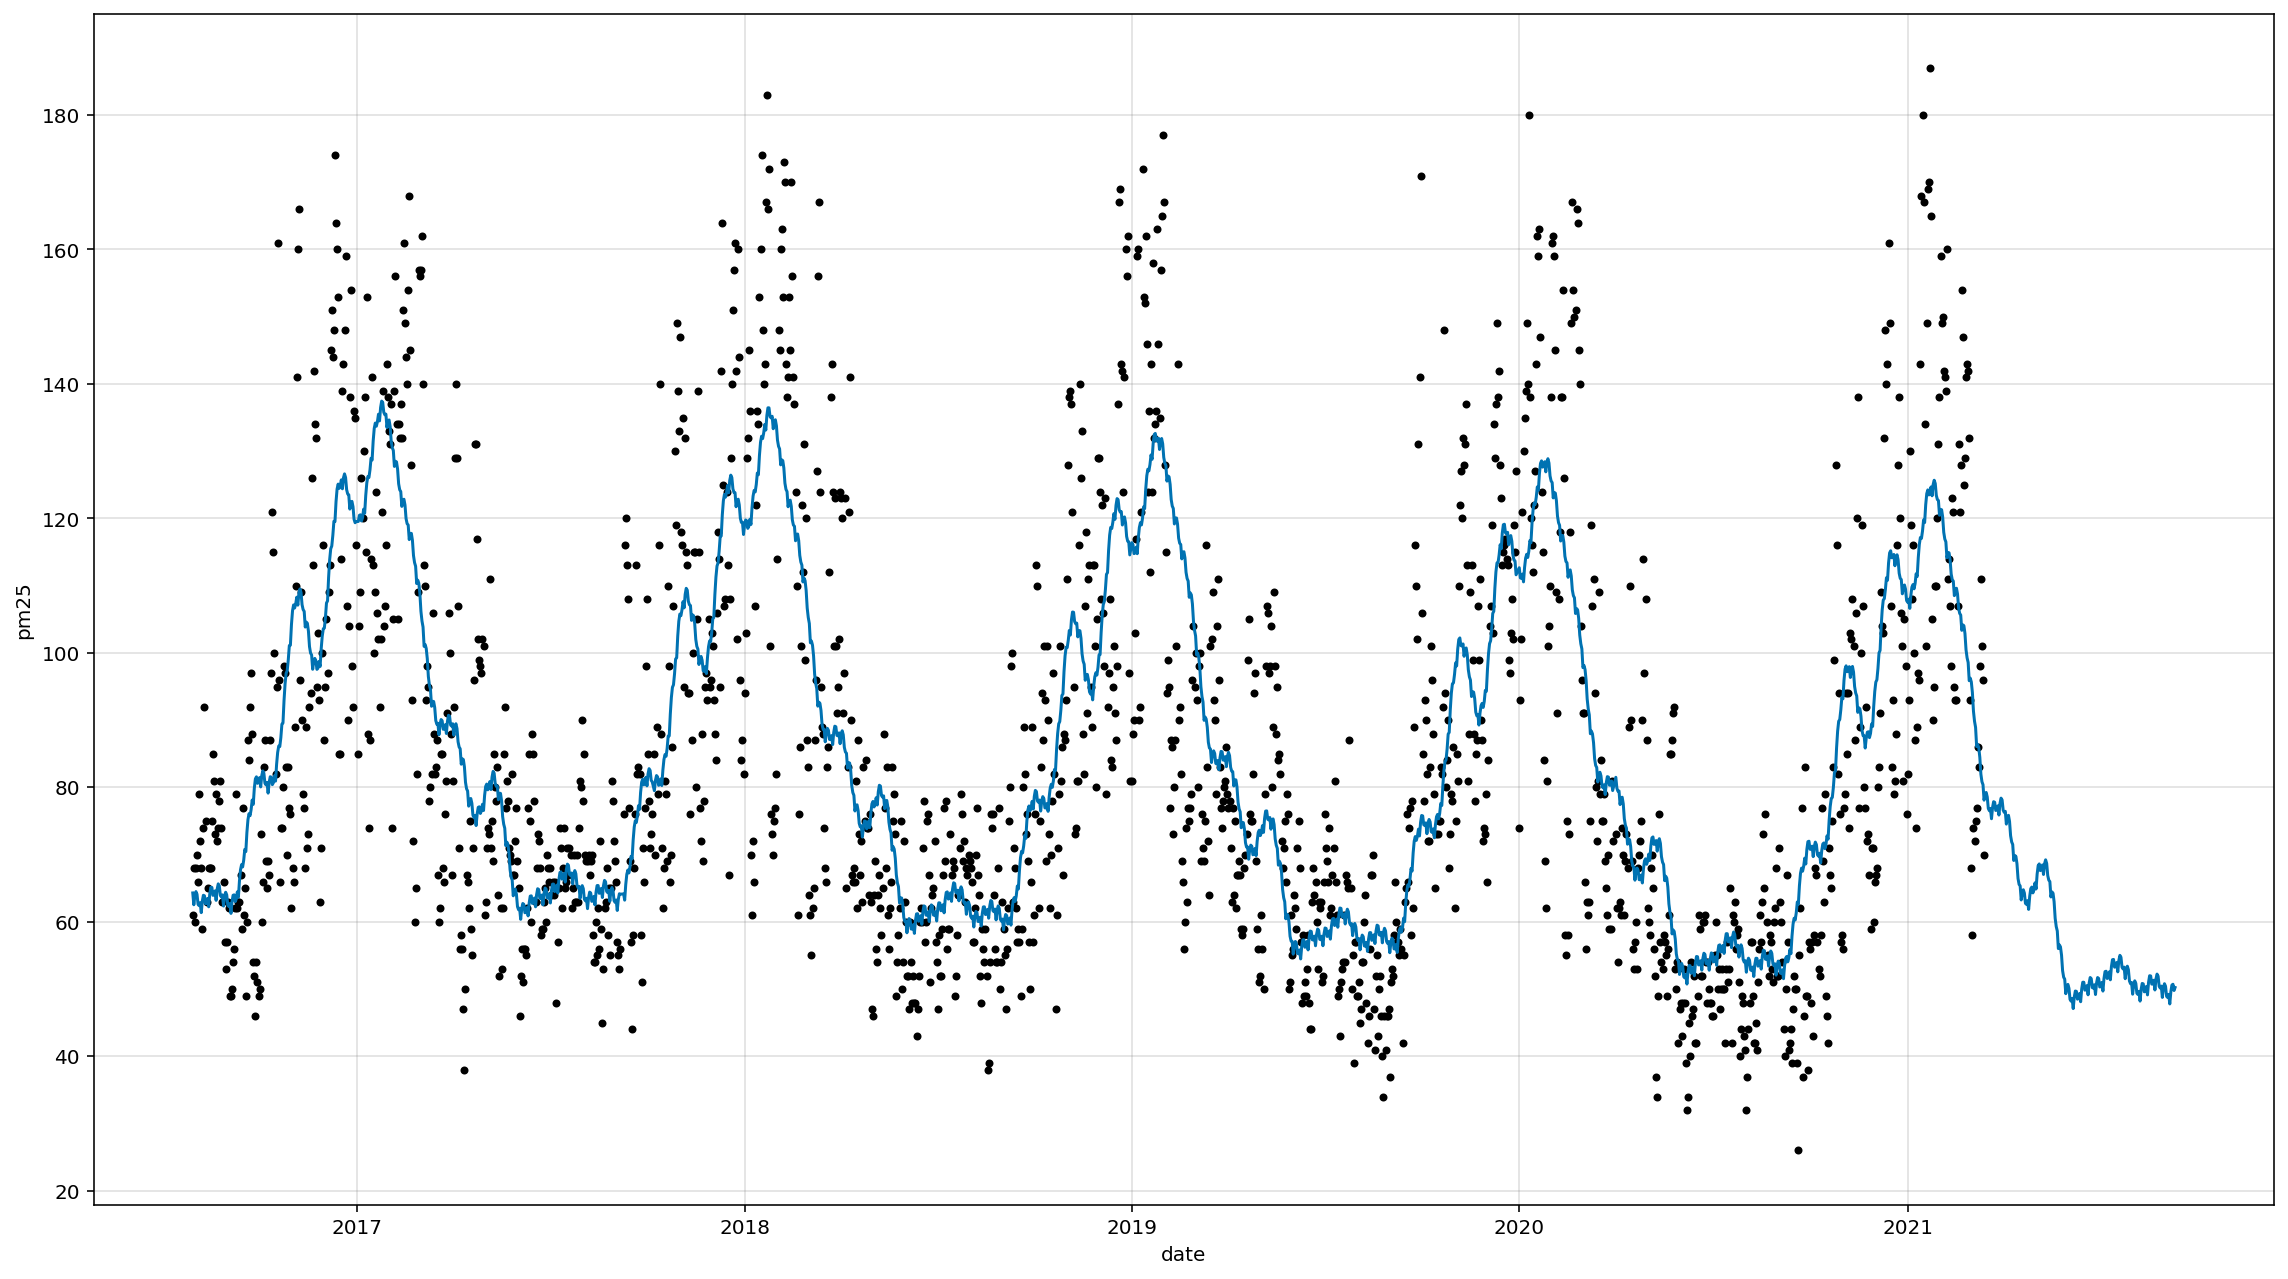

In [34]:
fig=model.plot(forecast, uncertainty=False, figsize=(16, 9), xlabel='date', ylabel=y_col)

### plot weekly and yearly trend

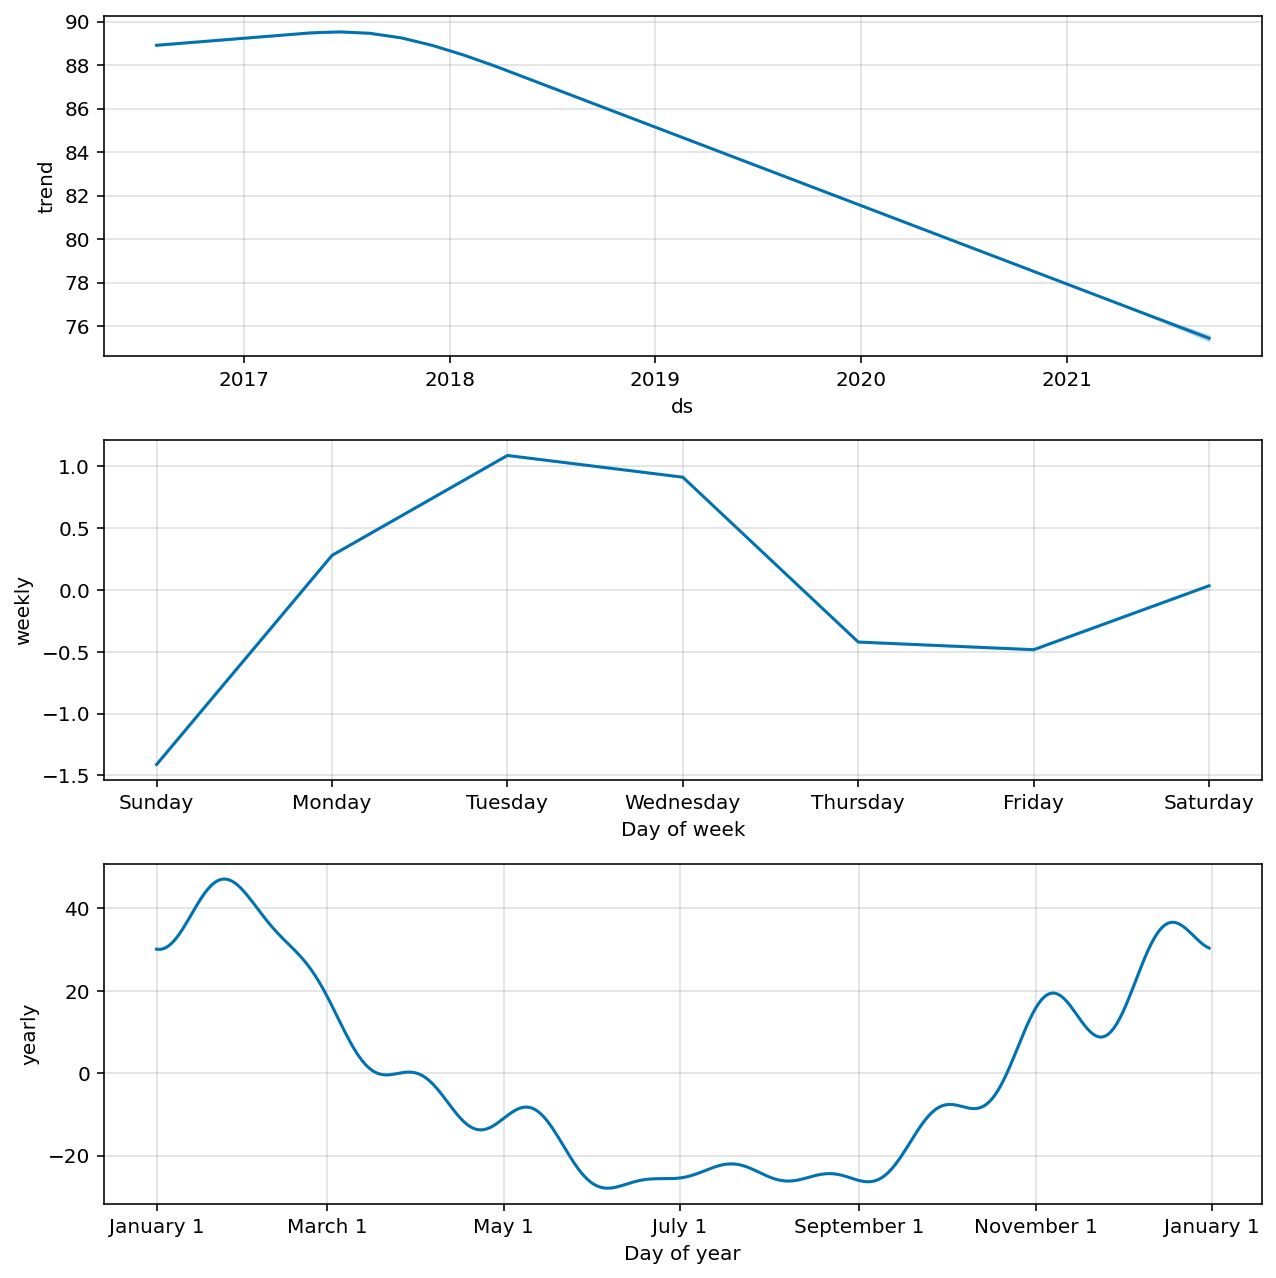

In [35]:
fig=model.plot_components(forecast)